## Load MatLab File using SciPy

In [1]:
import sklearn as sklearn
import numpy as np                #for numerical operations
import pandas as pd               #for data reading/structure
import matplotlib.pyplot as plt          #Used for plotting
from scipy.optimize import curve_fit
import scipy.signal as signal
from functools import partial
import multiprocessing
from contextlib import contextmanager
import sys
from matplotlib.lines import Line2D
import copy 
from sklearn.decomposition import PCA, NMF, DictionaryLearning
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.ticker import StrMethodFormatter
from sklearn.cluster import KMeans
from os.path import dirname, join as pjoin
import scipy.io as sio
import matplotlib.ticker as ticker

### Load Data from Textfiles to a dataframe

In [2]:
####Load table from textfile
read=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefreadvec.txt',names=["Amp",'Res','Q','Phase'])
write=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefwritevec.txt',names=["Amp",'Res','Q','Phase'])

In [3]:
###Load Mat file to extract DC bias vector
mat_data = sio.loadmat('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\PZTbatch212BEPS_0003.mat',squeeze_me=True, struct_as_record=False)
dc=list(mat_data['dc_amp_vec_full']) ##### DC Bias Values 

In [4]:
num_acq=np.arange(0,900)    ######900 acqusisitions. Collection order is row ordered
acq=np.tile(num_acq,192)
len(acq)

cycle=np.arange(0,3) ########### Cycle number. First 900 acquistion is cycle1 for first DC value. Second 900 for cycle2
# for first DC values
cycle=np.repeat(cycle,900)
cycle=np.tile(cycle,64)
len(cycle)

dc=dc[0:64]        ######### DC Bias Values associated with a single cycle

In [5]:
def reshape_data(df):

#### Create inital index object for the Dataframe. Using .from_product() interate the index to reflect the organization
#of the raw data:The first 30 rows of the array correspond to the SHO coefficients for the first step of the first 
#loop and for the 30 x coordinates along the first y coordinate i.e. SHOcoef(:,1,1,1,1). Then the next 30 rows would 
#be the first step of the first loop for 30 x coordinates along the 2nd y coordinate i.e. SHOcoef(:,2,1,1,1).  
    x_cord=np.array(range(30))
    y_cord=np.array(range(30))
    chirps=np.array(range(192))
    parameters=[chirps,x_cord,y_cord,]  
    index=pd.MultiIndex.from_product(parameters, names=['chirps','y', 'x',])
    df=df.set_index(index)

##### Add Index and Reorganize such that aqusition pionts are along axis=0 (rows) and chirps are along axis=1 columns
    df=df.assign(cycle=cycle).set_index('cycle', append=True)  ####Add Cycle # label
    df=df.unstack(level=3).unstack(level=0).dropna(axis=1,how='all') ####Data Resort by Cycle Number and DC chirps. Original data 
##is grouped by DC step values: every 900 values is the response of every point for the first DC step and cycle. 
##The next 900 is all reponses to the first DC step in the next cycle. The data is ordered corecctly at this line but
## the chirp number labels now longer make sense


####Convert labels from XY coridinate pairs to acquisition numbers
    df=df.set_index(num_acq,)
    df.index.name='Acq#'  

###Create Dictionary to Map chirp labels Bias values. 
    chirp_keys=chirps
    chirp_values=np.repeat(dc,3)
    bias_dict = {chirp_keys[i]: chirp_values[i] for i in range(len(chirp_keys))}   ###Create Dictionary to Map chirp labels Bias values

#### Use dictionary to create new array for indexing
    order1=df.columns.get_level_values('chirps')
    bias=[]
    for i in order1:
        bias.append(bias_dict[i])
    bias=np.array(bias)

##### Get other label arrays from existing data frame. Cycles and Variable Labels were not effected by reordering 
    cycles=df.columns.get_level_values('cycle')
    var=df.columns.get_level_values(None)

### Create a new Multiindex for with relevent Variable, Cycle, Chirp Number, NAd DC bias labels
    col_index=pd.MultiIndex.from_arrays([var,cycles,np.tile(chirps,4),bias], names=['Variable','cycle#','chirp#', 'DC',])


### Put data into new Dataframe with accruate index and column information
    df=pd.DataFrame(df.values, index=df.index, columns=col_index)

#### Calculate PR response from SHO coefficients
    pr= pd.DataFrame(index=df.index,columns=df['Amp'].columns)
    pr=df['Amp']*np.sin(df['Phase'])

#### Add PR to Refit data frame
    df=pd.concat(dict(Amp = df['Amp'], Phase = df['Phase'], Res=df['Res']/1000, Q=df['Q'],PR=pr),axis=1)
    
###Adjust the phase to make phase lie between 0 and pi for plotting
    offset=-1.55
    df['Phase']=df['Phase']+np.abs(offset)
    
##Convert phase to degrees
    df['Phase']=df['Phase']*(180/np.pi)
    return df

## Data Cleaning and Filtering

In [6]:
def remove_q(df):
####### Map and Remove points the Data set with Q values larger than 500 and less than 0
    test = df['Q'].applymap(lambda x: np.nan if x< 0 else x)
    test = test.applymap(lambda x: np.nan if x> 500 or x == 500 else x)
    
 ######Make a copy of the input df   
    df_nan=df.copy()

#####
    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_nan[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

    return df_nan

def impute_fill(df,mean,std):
########Define Bounds###########
    mean=mean ### use df_means
    std=std ### use df_devs
        
    upper=mean + (3*std)
    lower=mean - (3*std)
    print('Upper Limit: ', upper)
    print('Lower Limit: ', lower)

######Make a copy of the input df   
    df_fill=df.copy()

####### Map and Remove points the Data set with Q values larger than upper and less than lower
    test = df['Q'].applymap(lambda x: np.nan if x < lower else x)
    test = test.applymap(lambda x: np.nan if x > upper else x)

    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_fill[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

        df_fill[var]=df_fill[var].interpolate(method='linear',limit=2 ,limit_direction='forward',limit_area='inside', axis=1)
        df_fill[var]=df_fill[var].fillna(method='backfill',axis='columns')     #Axis = columns to back fill from the next DC bias in the waveform at the same point
        df_fill[var]=df_fill[var].fillna(method='ffill',axis='columns') ###forward fill to get the last chirps
        
    return df_fill

In [7]:
###Re-order data,
write=reshape_data(write)
read=reshape_data(read)

In [8]:
##Make a Dictionary of Mean and Standard Deviation Values 
def scales_dict(df):
    var_list=['Amp','Phase','PR','Res','Q']
    means=[df['Amp'].mean(skipna=True).mean(skipna=True),df['Phase'].mean(skipna=True).mean(skipna=True),df['PR'].mean(skipna=True).mean(skipna=True),df['Res'].mean(skipna=True).mean(skipna=True),df['Q'].mean(skipna=True).mean(skipna=True)]
    means_dict={var_list[i]: means[i] for i in range(len(var_list))} 
    devs=[df['Amp'].std(skipna=True).mean(skipna=True),df['Phase'].std(skipna=True).mean(skipna=True),df['PR'].std(skipna=True).mean(skipna=True),df['Res'].std(skipna=True).mean(skipna=True),df['Q'].std(skipna=True).mean(skipna=True)]
    std_dict={var_list[i]: devs[i] for i in range(len(var_list))} 

    return means_dict,std_dict

In [9]:
read_means,read_devs=scales_dict(read)
write_means,write_devs=scales_dict(write)

In [10]:
# ####remove chirps associated with "bad" q values
write=remove_q(write)   
read=remove_q(read)


locs=900
cycles=3
chirps=64   ###64 BEpackets per cycle
be_samples=cycles*chirps*locs*2         #####scale by 2 since there are 2 dataframes: read and write

len_write=len(np.where(write['Q'].isnull())[0])
len_write

len_read=len(np.where(read["Q"].isnull())[0])
len_read
print ("{0:.1%}".format((len_write+len_read)/be_samples))  

2.7%


In [11]:
####Extract A copy of each dataframe for ploting nan reponses during analysis
write_nan=write.copy()
read_nan=read.copy()

In [12]:
##Filter by Q limits (values of q more than 3 standard deviation from the mean)
write=impute_fill(write,mean=write_means['Q'],std=write_devs['Q'])   

##Filter by Q limits (values of q more than 3 standard deviation from the mean)
read=impute_fill(read,mean=read_means['Q'],std=read_devs['Q'])

Upper Limit:  420.2031366496445
Lower Limit:  91.54938337259222
Upper Limit:  463.6871987264025
Lower Limit:  59.05405613017291


In [13]:
###Remove first few inital chirps from cycle 0
read.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)
read_nan.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)

write.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)
write_nan.drop([0,1,2,3],axis=1,level='chirp#',inplace=True)

In [14]:
read_means,read_devs=scales_dict(read)           #######Run Again to get new scaling values for later dimensional reduction
write_means,write_devs=scales_dict(write)
read_means['Res']

330.9834718019076

In [15]:
#Some Checks
df= write
print(np.shape(df["Q"]))
print(np.where(df.isnull()))  #### machine learning cannot have Nan or Inf values
print(np.where(df['Q']>500)) ##### chirps due to poor SHO fits are gone
print(np.where(df['Q']<5))

df= read
print(np.shape(df["Q"]))
print(np.where(df.isnull()))  #### machine learning cannot have Nan or Inf values
print(np.where(df['Q']>500)) ##### chirps due to poor SHO fits are gone
print(np.where(df['Q']<5))

(900, 188)
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(900, 188)
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Basic Plot Funtions

In [16]:
####Extract A copy of each dataframe for ploting point reponses during analysis
write_1=write.copy()
read_1=read.copy()

In [17]:
import matplotlib.colors as mcol
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
%matplotlib notebook

####Make a dicionary of Unit labels for plotting
var_list=['Amp','Phase','PR','Res','Q',]
units=["(a.u)",'($\circ$)','(a.u.)','(kHz)','']
unit_dict={var_list[i]: units[i] for i in range(len(var_list))} 

#####Define some global Plotting Parameters
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.15
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5

#####Define Plot functions for Data
#####Scatter Function to view all data
def plot_nan(df_nan,df,var,pnt,xlabel,c1):
    x0 = dc[4:]
    x = dc
    c1= c1
    c2='r'
    
    y1_nan = df_nan[var][0][pnt:pnt+1].values[0].copy() ####### Highight Values that have been Filled in cycle 1
    y1 = df[var][0][pnt:pnt+1].values[0].copy()######Cycle 1
    mask1=np.full((len(y1)),np.nan)
    mask1[np.where(np.isnan(y1_nan))]=y1[np.where(np.isnan(y1_nan))]
    
    y2_nan = df_nan[var][1][pnt:pnt+1].values[0].copy()######Cycle 2
    y2 = df[var][1][pnt:pnt+1].values[0].copy()
    mask2=np.full((len(y2)),np.nan)
    mask2[np.where(np.isnan(y2_nan))]=y2[np.where(np.isnan(y2_nan))]
    
    y3_nan = df_nan[var][2][pnt:pnt+1].values[0].copy()######Cycle 3
    y3 = df[var][2][pnt:pnt+1].values[0].copy()
    mask3=np.full((len(y3)),np.nan)
    mask3[np.where(np.isnan(y3_nan))]=y3[np.where(np.isnan(y3_nan))]
    

    plt.plot(x0,y1,color=c1,linestyle='-', markersize=1.0,label='cycle 1')
    plt.plot(x,y2,color=c1,linestyle=':', markersize=1.0,label='cycle 2')
    plt.plot(x,y3,color=c1,linestyle='--', markersize=1.0,label='cycle 3')
    plt.scatter(x0, mask1, c=c2, s=10.0,marker='o',label='NaN')
    plt.scatter(x, mask2, c=c2,s=10.0, marker='o')
    plt.scatter(x, mask3, c=c2,s=10.0, marker='o')
    
    ax = plt.gca()
    y_lims=[]
    for i in [y1,y2,y3]:
        first_data= i
        y_lims.append(first_data.max())
        y_lims.append(first_data.min())
    ymin=np.min(y_lims)
    ymax=np.max(y_lims)
    yrange = np.abs(ymin-ymax)
    incr_range = yrange*0.1    
    #ax.set_ylim([ymin-incr_range,ymax+incr_range])
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10, -5,0,5, 10])
    if var =='Res' or 'Q':
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    else:
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
        ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.set_yticks([ymin,((ymin)+(yrange/2)),ymax])
    if var=="Res":
        plt.ylabel('$\omega$ '+unit_dict[var])
    else:
        plt.ylabel(var+' '+unit_dict[var])
    if xlabel==True:
        plt.xlabel("Bias (V)")
    else:
        plt.xlabel(" ",fontsize=10)
        ax.set_xticklabels([])
    plt.show()
    return ymin,ymax
    
    
####### Plot NANs for All Responses for each point in space
def nan_all(df,pnt,Ec,Ec_,label):
    fig= plt.figure(figsize=(6,4), dpi=100)
    gs= gridspec.GridSpec(2, 3,height_ratios=[1,1], width_ratios = [1.0,1,1],hspace=0.3,wspace=0.4,top=0.95, bottom=0.135, left=0.07, right=0.95)

    #####Plot the Label Map
    ax_map = fig.add_subplot(gs[0,0])

    pntX=np.full((900),False)
    pntX[pnt]=True
    im1=pntX.reshape(30,30)
    im1=np.rot90(im1)
    colors = ["white","red"]
    cmap1 =  matplotlib.colors.ListedColormap(colors)

    plt.imshow(im1,cmap=cmap1,origin='lower',interpolation='none', alpha=.85)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    ax_map.annotate("Point = "+str(pnt),(0.01,0.85),xycoords='axes fraction',fontweight='normal')
    #####Plot the Responses
    ax_amp=fig.add_subplot(gs[0,1])
    plot_nan(df_nan,df,"Amp",pnt,True,c1)
    ax_amp.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.annotate('$E_{c+}$', (Ec-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    ax_amp.annotate('$E_{c-}$', (Ec_-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    
    ax_phase=fig.add_subplot(gs[0,2])
    plot_nan(df_nan,df,'Phase',pnt,True,c1)
    ax_phase.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_phase.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    
    ax_pr=fig.add_subplot(gs[1,0])
    plot_nan(df_nan,df,'PR',pnt,True,c1)
    ax_pr.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_pr.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    
    ax_res=fig.add_subplot(gs[1,1])
    plot_nan(df_nan,df,'Res',pnt,True,c1)
    ax_res.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_res.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    
    ax_q=fig.add_subplot(gs[1,2])
    plot_nan(df_nan,df,'Q',pnt,True,c1)
    ax_q.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_q.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    
    
    handles, labels = ax_q.get_legend_handles_labels()
    #fig.legend(handles, labels, loc=(0.275,0.01),ncol=4,frameon=False,handletextpad=0.5,
               #handleheight=1.0, handlelength=1.0,labelspacing=0.05,framealpha=0.1,markerscale=1.0)
    return ax_map

<IPython.core.display.Javascript object>


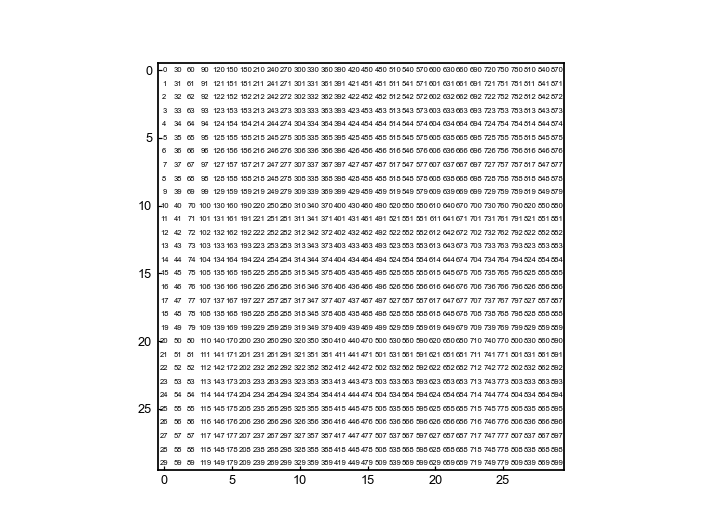

In [18]:
####### the ordering of the data pionts is off between Matlab and Python: Use this map as a 
# reference for acquisition numbers (index) relative to spatial mapping

fig, ax = plt.subplots()
pnts=np.arange(0,900)
pnts=pnts.reshape(30,30)

ax.imshow(pnts,cmap='magma',alpha=0.0)
for i in range(30):
    for j in range(30):
        text = ax.text(i, j, pnts[i, j],
                       ha="center", va="center", color="black",fontsize=5)
        
#plt.savefig('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\Figures\\Pnts_ref_map.jpeg',dpi=300)

### Data Preprocessing for ML Analysis

In [19]:
#####Remove Means and Standardize by Standard Deviation
df=write
for var in ['Amp', 'PR', 'Phase', 'Q', 'Res']:
    df[var]=df[var].sub(df[var].mean(axis=1, skipna=True), axis=0) #### axis =1 to look across pionts in space (rows) to correct for drift in resonance values during measurement, skipna =True to skip NaN values    
######z-standardization
    mean_val = df[var].mean().mean()             #### will already be zero from proceeding step
    std_val = df[var].std().mean()
    df[var]=df[var].sub(mean_val)/std_val   ########center at zero
df=read
for var in ['Amp', 'PR', 'Phase', 'Q', 'Res']:
    df[var]=df[var].sub(df[var].mean(axis=1, skipna=True), axis=0) #### axis =1 to look across pionts in space (rows) to correct for drift in resonance values during measurement, skipna =True to skip NaN values    
######z-standardization
    mean_val = df[var].mean().mean()             #### will already be zero from proceeding step
    std_val = df[var].std().mean()
    df[var]=df[var].sub(mean_val)/std_val   ########center at zero

In [20]:
###Data Stacking ALL CYCLES 
PR_res=pd.concat(dict(PR_r0=read["PR"][0],PR_r1=read["PR"][1],PR_r2=read["PR"][2],
                      Res_r0=read["Res"][0],Res_r1=read["Res"][1],Res_r2=read["Res"][2],
                      PR_w0=write["PR"][0], PR_w1=write["PR"][1],PR_w2=write["PR"][2]),axis=1,) ##Read + Write--All Cycles

In [21]:
###### Stacked Datasets needs mean of zero and variance near 1 for best ML preformance
stack=PR_res
print('Stacked Mean: ',round(stack.mean().mean(),10))
print('Stacked STD: ',round(stack.std().mean(),5))
print('Read Mean PR: ',round(read['PR'].mean().mean(),3))
print('Read STD PR: ',round(read['PR'].std().mean(),3))
print('Read Mean Res: ',round(read['Res'].mean().mean(),3))
print('Read STD Res: ',round(read['Res'].std().mean(),3))
print('Write Mean PR: ',round(write['PR'].mean().mean(),3))
print('Write STD PR: ',round(write['PR'].std().mean(),3))

Stacked Mean:  0.0
Stacked STD:  1.0
Read Mean PR:  0.0
Read STD PR:  1.0
Read Mean Res:  -0.0
Read STD Res:  1.0
Write Mean PR:  0.0
Write STD PR:  1.0


In [22]:
##### Analysis Plot Functions  
    
#####Multi-Parameter Analysis    
def plot_multi_1(df,cycles,comp,c):
    x=dc
    x0 = dc[4:]
    y1=(df['PR_r0'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"] #cycle 1
    y2=(df['PR_r1'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"]#cycle 2
    y3=(df['PR_r2'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"]#cycle 3
        
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
        
    list1=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list1.append(data.max())
        list1.append(data.min())
    
    fig = plt.gcf()
    ax = plt.gca()
    ymin=min(list1)
    ymax=max(list1)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)")
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax
    
def plot_multi_2(df,cycles,comp,c):                 #: here Read Res response
    x=dc
    x0 = dc[4:]

    y1=(df['Res_r0'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"]#cycle 1
    y2=(df['Res_r1'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"]#cycle 2
    y3=(df['Res_r2'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"]#cycle 3
   
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
    list2=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list2.append(data.max())
        list2.append(data.min())

    
    fig = plt.gcf()
    ax = plt.gca()
    
    ymin=min(list2)
    ymax=max(list2)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)")
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax
    
def plot_multi_3(df,cycles,comp,c):    #: here Write PR response
    x=dc
    x0 = dc[4:]

    y1=(df['PR_w0'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"]#cycle 1
    y2=(df['PR_w1'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"]#cycle 2
    y3=(df['PR_w2'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"]#cycle 3
   
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
    list3=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list3.append(data.max())
        list3.append(data.min())

    
    fig = plt.gcf()
    ax = plt.gca()
    
    ymin=min(list3)
    ymax=max(list3)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)")
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax

### K-means--Outlier Removal

In [23]:
##### Removal of Outlier Points
n=9
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(PR_res)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=PR_res.columns)

In [24]:
def comp_lims(n,analysis_df):
    cycles=True
    res_lims=[]
    pr_lims=[]
    for i in range(n):
        ymin,ymax = plot_multi_1(analysis_df,cycles,i,'r')
        pr_lims.append(ymin)
        pr_lims.append(ymax)
        ymin,ymax = plot_multi_3(analysis_df,cycles,i,'r')
        pr_lims.append(ymin)
        pr_lims.append(ymax)
        ymin,ymax = plot_multi_2(analysis_df,cycles,i,'r')
        res_lims.append(ymin)
        res_lims.append(ymax)
    pr_min=np.min(pr_lims)
    pr_max=np.max(pr_lims)
    pr_range = np.abs(pr_min-pr_max)
    incr_pr = pr_range*0.1
    lim_dict_pr={'max':pr_max,
              'min':pr_min,
              'range':pr_range,
              'incr':incr_pr}


    res_min=np.min(res_lims)
    res_max=np.max(res_lims)
    res_range = np.abs(res_min-res_max)
    incr_res = res_range*0.1
    
    lim_dict_res={'max':res_max,
              'min':res_min,
              'range':res_range,
              'incr':incr_res}
    return lim_dict_pr,lim_dict_res  

In [25]:
def outlier_lims(pnts,var):
    var_lims=[]
    for i in pnts:
        ymin,ymax=plot_nan(read_nan,read_1,var,i,False,'black')
        var_lims.append(ymin)
        var_lims.append(ymax)
    
    out_max=np.max(var_lims)
    out_min=np.min(var_lims)
    out_range = np.abs(out_min-out_max)
    incr_out = out_range*0.1
    out_dict={'max':out_max,
              'min':out_min,
              'range':out_range,
              'incr':incr_out}
    return out_dict  

<IPython.core.display.Javascript object>


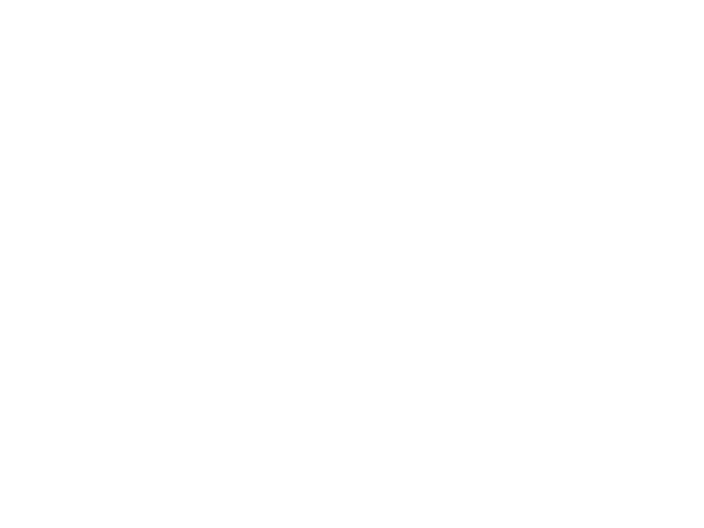

<IPython.core.display.Javascript object>


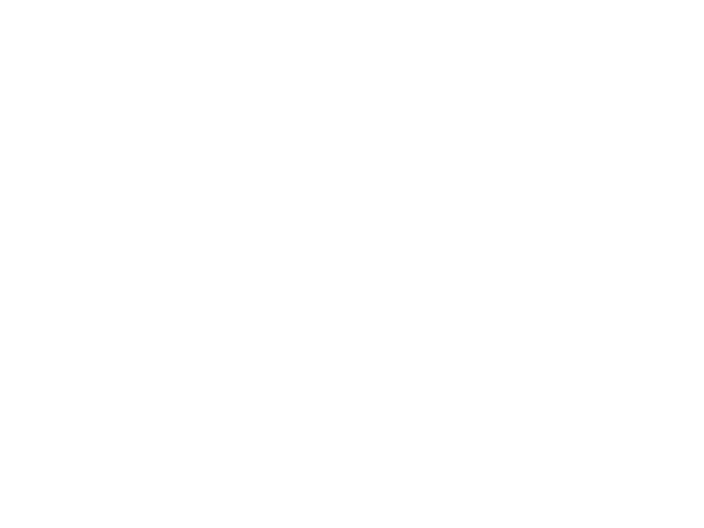

In [26]:
####Calculate initial limits for plotting component behaviors
lim_dict_pr,lim_dict_res= comp_lims(9, kmeans_comps)
plt.close()
######Calculate initial limits for plotting outlier responses
var='Amp'
amp=outlier_lims([277,263,44,557,35],var)

var='Phase'
phase=outlier_lims([277,263,44,557,35],var)

var='PR'
pr=outlier_lims([277,263,44,557,35],var)

var='Res'
res=outlier_lims([277,263,44,557,35],var)

var='Q'
q=outlier_lims([277,263,44,557,35],var)

plt.close('all')

In [27]:
def nan_subplot(comp,color,ax,gs,df,pnt,Ec,Ec_,label,ylabel):   ###  color is the color of the piont in the map, label is the coercive field label
    ax = fig.add_subplot(gs[0,0])
    pntX=np.full((900),False)
    pntX[pnt]=True
    im1=pntX.reshape(30,30)
    im1=np.rot90(im1)
    colors = ["white",color]
    cmap1 =  matplotlib.colors.ListedColormap(colors)

    plt.imshow(im1,cmap=cmap1,origin='lower',interpolation='none', alpha=.85)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    ax.annotate("Point = "+str(pnt),(0.05,0.05),xycoords='axes fraction',fontweight='normal')
    ax.annotate(r"$k_{}$".format(comp),(0.04,0.88),xycoords='axes fraction',fontsize=10)
    #####Plot the Responses
    ax_amp=fig.add_subplot(gs[1,0])
    plot_nan(df_nan,df,"Amp",pnt,False,'black')
    ax_amp.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_amp.annotate('$E_{c+}$', (Ec-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    ax_amp.annotate('$E_{c-}$', (Ec_-1.5, label), textcoords='data',fontsize=8,
            horizontalalignment='center', verticalalignment='bottom')
    ax_amp.yaxis.set_label_position("right")
    ax_amp.yaxis.set_ticks_position("right")
    ax_amp.set_ylim([amp['min']-amp['incr'], amp['max']+amp['incr']])
    ax_amp.set_yticks([0,((amp['min'])+(amp['range']/2)),amp['max']])
    if ylabel==False:
        ax_amp.set_ylabel(' ', fontsize=10)
        ax_amp.set_yticklabels([])
        

    
    ax_phase=fig.add_subplot(gs[2,0])
    plot_nan(df_nan,df,'Phase',pnt,False,'black')
    ax_phase.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_phase.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_phase.yaxis.set_label_position("right")
    ax_phase.yaxis.set_ticks_position("right")
    ax_phase.set_ylim([phase['min']-phase['incr'], phase['max']+phase['incr']])
    #ax_phase.set_yticks([phase['min'],((phase['min'])+(phase['range']/2)), phase['max']])
    ax_phase.set_yticks([-70,100,270])
    if ylabel==False:
        ax_phase.set_ylabel(' ', fontsize=10)
        ax_phase.set_yticklabels([])
    
    
    
    ax_pr=fig.add_subplot(gs[3,0])
    plot_nan(df_nan,df,'PR',pnt,False,'black')
    ax_pr.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_pr.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_pr.yaxis.set_label_position("right")
    ax_pr.yaxis.set_ticks_position("right")
    ax_pr.set_ylim([pr['min']-pr['incr'], pr['max']+pr['incr']])
    ax_pr.set_yticks([pr['min'],0, pr['max']])
    if ylabel==False:
        ax_pr.set_ylabel(' ', fontsize=10)
        ax_pr.set_yticklabels([])
    
    ax_res=fig.add_subplot(gs[4,0])
    plot_nan(df_nan,df,'Res',pnt,False,'black')
    ax_res.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_res.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_res.yaxis.set_label_position("right")
    ax_res.yaxis.set_ticks_position("right")
    ax_res.set_ylim([res['min']-res['incr'],res['max']+res['incr']])
    #ax_res.set_yticks([res['min'],((res['min'])+(res['range']/2)), res['max']])
    ax_res.set_yticks([285,350,415])
    if ylabel==False:
        ax_res.set_ylabel(' ', fontsize=10)
        ax_res.set_yticklabels([])
        

    
    ax_q=fig.add_subplot(gs[5,0])
    plot_nan(df_nan,df,'Q',pnt,True,'black')
    ax_q.axvline(x=Ec_, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_q.axvline(x=Ec, ymin=0, ymax=1,linestyle='--',linewidth=0.5, color='black')
    ax_q.yaxis.set_label_position("right")
    ax_q.yaxis.set_ticks_position("right")
    ax_q.set_ylim([q['min']-q['incr'],q['max']+q['incr']])
    #ax_q.set_yticks([q['min'],((q['min'])+(q['range']/2)), q['max']])
    ax_q.set_yticks([60,260, 460])
    if ylabel==False:
        ax_q.set_ylabel(' ', fontsize=10)
        ax_q.set_yticklabels([])
    
    handles, labels = ax_q.get_legend_handles_labels()
    return handles,labels
   

### Supplemental Figure S9 

<IPython.core.display.Javascript object>


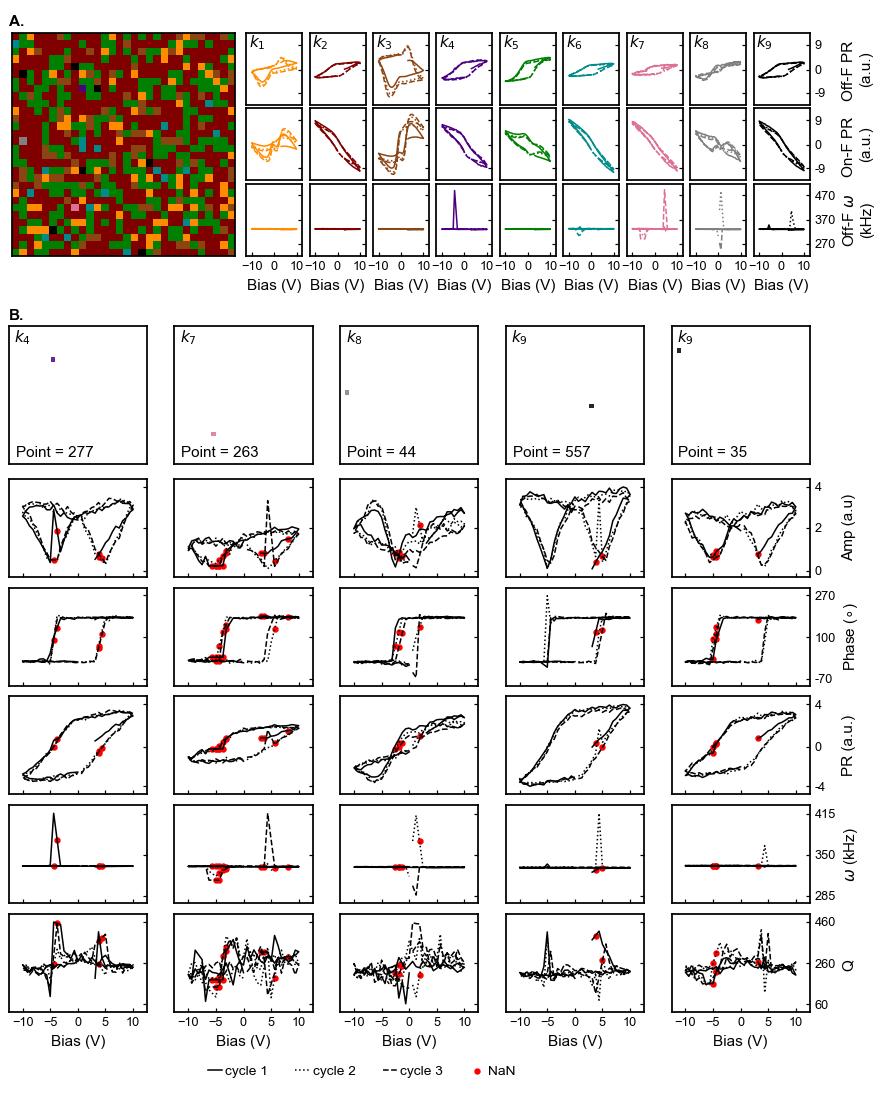

In [28]:
###### Plotter for Multivariable K means
cycles=True     #####True for all cycles
df=kmeans_comps
width_ratios=[4.1,]
for i in range(n):
    width_ratios.append(1.0)


fig= plt.figure(figsize=(8.0,10.0), dpi=100)
gs= gridspec.GridSpec(7, 5,height_ratios=[2.9,0.1,1.5,1.5,1.5,1.5,1.5], width_ratios = [1,1,1,1,1],
                      hspace=0.25,wspace=0.2,top=0.97, bottom=0.08, left=0.01, right=0.92)
gs_kmeans=gs[0,:].subgridspec(3,n+1,height_ratios=[1,1,1], width_ratios = width_ratios, hspace=0.05,wspace=0.1)

c = ['darkorange','maroon','saddlebrown','indigo','green','darkcyan','palevioletred','grey','black']
cscale = matplotlib.colors.ListedColormap(c)


ax_a=fig.add_subplot(gs[0,0])
ax_a.axes.get_yaxis().set_visible(False)
ax_a.axes.get_xaxis().set_visible(False)
ax_a.set_frame_on(False)
ax_a.annotate('A.',(0,1.03),xycoords='axes fraction', color='k',fontsize=10,fontweight='bold')

ax_b=fig.add_subplot(gs[2,0])
ax_b.axes.get_yaxis().set_visible(False)
ax_b.axes.get_xaxis().set_visible(False)
ax_b.set_frame_on(False)
ax_b.annotate('B.',(0,1.01),xycoords='axes fraction', color='k',fontsize=10,fontweight='bold')


#####Plot the Label Map
ax = fig.add_subplot(gs_kmeans[:,0])
im=kmeans.labels_.reshape(30,30)
im=np.rot90(im)
plt.imshow(im, cmap=cscale,origin='lower')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

######Assign Component Limits######
pr_min=lim_dict_pr['min']
pr_max=lim_dict_pr['max']
incr_pr=lim_dict_pr['incr']
pr_range=lim_dict_pr['range']
    
res_min= lim_dict_res['min']
res_max=lim_dict_res['max']
incr_res=lim_dict_res['incr']
res_range=lim_dict_res['range']

#####Plot the first Variable
reorder=[0,1,2,3,4,5,6,7,8]
for i,j in zip(reorder,range(n)):
    color=c[i]
    ax=fig.add_subplot(gs_kmeans[0,j+1])
    im=plot_multi_1(df,cycles,i,c=color)
    ax.annotate(r"$k_{}$".format(i+1),(0.05,0.80),xycoords='axes fraction',fontsize=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([pr_min-incr_pr, pr_max+incr_pr])
    ax.set_yticks([pr_min+incr_pr,0, pr_max-incr_pr])
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ylabel("Off-F PR \n(a.u.)",fontsize=10)
    if j+1 !=n:
        ax.set_yticklabels([])
        ax.set_ylabel(' ', fontsize=10)
        
#####Plot the Second Variable 
for i,j in zip(reorder,range(n)):
    color=c[i]
    ax=fig.add_subplot(gs_kmeans[2,j+1])
    im=plot_multi_2(df,cycles,i,c=color)
    plt.ylabel("Off-F $\omega$ \n(kHz)",fontsize=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.gca().axes.get_xaxis().set_visible(False)
    ax.set_ylim([res_min-incr_res, res_max+incr_res])
    #ax.set_yticks([res_min+incr_res,((res_min)+(res_range/2)),res_max-incr_res])
    ax.set_yticks([270,370,470])
    ax.set_xticks([-10, 0, 10])
    if j+1 !=n:
        ax.set_yticklabels([])
        ax.set_ylabel(' ', fontsize=10)
        
#####Plot the Third Variable 
for i,j in zip(reorder,range(n)):
    color=c[i]
    ax=fig.add_subplot(gs_kmeans[1,j+1])
    im=plot_multi_3(df,cycles,i,c=color)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ylabel("On-F PR \n(a.u.)",fontsize=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([pr_min-incr_pr, pr_max+incr_pr])
    ax.set_yticks([pr_min+incr_pr,0, pr_max-incr_pr])
    if j+1 !=n:
        ax.set_yticklabels([])
        ax.set_ylabel(' ', fontsize=10)

        
#####Outlier Responses 
cycles=True
df_nan=read_nan
Ec=np.nan
Ec_=np.nan
label=8.13

                
ax_n4=fig.add_subplot(gs[2:,0])
gs_n4=gs[2:,0].subgridspec(6,1,height_ratios=[1.5,1,1,1,1,1], width_ratios =[1.0] ,hspace=0.1,wspace=0.3)
ax_n4.axes.get_yaxis().set_visible(False)
ax_n4.axes.get_xaxis().set_visible(False)
ax_n4.set_frame_on(False)
nan_subplot(4,'indigo',ax_n4,gs_n4,read_1,277,Ec,Ec_,label,False)
        
ax_n7=fig.add_subplot(gs[2:,1])
gs_n7=gs[2:,1].subgridspec(6,1,height_ratios=[1.5,1,1,1,1,1], width_ratios =[1.0] ,hspace=0.1,wspace=0.3)
ax_n7.axes.get_yaxis().set_visible(False)
ax_n7.axes.get_xaxis().set_visible(False)
ax_n7.set_frame_on(False)
nan_subplot(7,'palevioletred',ax_n7,gs_n7,read_1,263,Ec,Ec_,label, False)

ax_n8=fig.add_subplot(gs[2:,2])
gs_n8=gs[2:,2].subgridspec(6,1,height_ratios=[1.5,1,1,1,1,1], width_ratios =[1.0] ,hspace=0.1,wspace=0.3)
ax_n8.axes.get_yaxis().set_visible(False)
ax_n8.axes.get_xaxis().set_visible(False) 
ax_n8.set_frame_on(False)
nan_subplot(8,'grey',ax_n8,gs_n8,read_1,44,Ec,Ec_,label,False)

ax_n9=fig.add_subplot(gs[2:,3])
gs_n9=gs[2:,3].subgridspec(6,1,height_ratios=[1.5,1,1,1,1,1], width_ratios =[1.0] ,hspace=0.1,wspace=0.3)
ax_n9.axes.get_yaxis().set_visible(False)
ax_n9.axes.get_xaxis().set_visible(False)
ax_n9.set_frame_on(False)
nan_subplot(9,'black',ax_n9,gs_n9,read_1,557,Ec,Ec_,label,False)

ax_n9_=fig.add_subplot(gs[2:,4])
gs_n9_=gs[2:,4].subgridspec(6,1,height_ratios=[1.5,1,1,1,1,1], width_ratios =[1.0] ,hspace=0.1,wspace=0.3)
ax_n9_.axes.get_yaxis().set_visible(False)
ax_n9_.axes.get_xaxis().set_visible(False)
ax_n9_.set_frame_on(False)
handles,labels=nan_subplot(9,'black',ax_n9_,gs_n9_,read_1,35,Ec,Ec_,label,True)



fig.align_ylabels()
fig.legend(handles, labels,loc=((0.23,0.015)),ncol=4, fontsize=9,frameon=False,handletextpad=0.25,framealpha=0.1,markerscale=1,handlelength=1)
#plt.suptitle('PR and RES Stacked Read Write Cycles 2+3', fontsize=12)

<IPython.core.display.Javascript object>


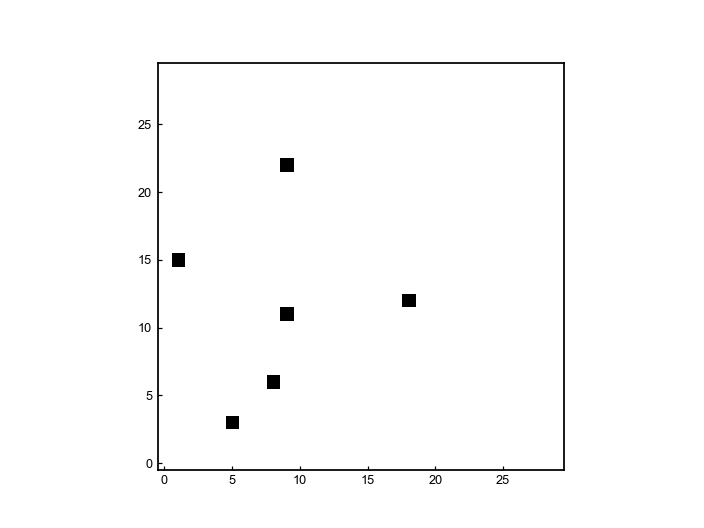

[ 44 176 263 277 288 557]


In [29]:
####Make a mask of locations to igonore in DL analysis
A = kmeans.labels_
mask = np.full((900),False) #### array of false


mask[np.where(A==3)[0]]=True
mask[np.where(A==6)[0]]=True
mask[np.where(A==7)[0]]=True

mask[176]=True    ########## These values come from outliers with poor SHO fits within 
                    ######## the k=9 compoenent of Supplementary Figure 9
mask[288]=True
mask[557]=True  



mask_map = mask.reshape(30,30)   ###### map of points you want to ignore
mask_map=np.rot90(mask_map)
plt.figure()
fig=plt.plot(constrained_layout=True)
plt.imshow(mask_map,origin='lower',cmap='binary')

print((np.where(mask==True)[0]))

In [ ]:
####Examine points idenified by K-means clustering. Note the poor SHO fitting is indicated by a spike in the amplitude
####coresponding to a singular misfit data piont)
cycles=True
c1= "black"
df_nan=read_nan
Ec=np.nan
Ec_=np.nan
label=8.13
for i in (np.where(mask==True)[0]):
    pnt=i
    ax=nan_all(read_1,pnt,Ec,Ec_,label)


In [30]:
plt.close("all")

## Dictionary Learning

In [31]:
#Define function that will run the model and extract results
def dict_learn(n,meas,flags, alp=1, quarter_flag=False):

    temp_data = analysis_data.values                                # Data to analyse
    
    dataset_analysis = temp_data[~flags,:]                          # Flags is basically the acquisition removal flags. It is a numpy array with size 2500 (for 50x50)
                                                                    # False means keep points, True means remove point. SO to remove point 136 flags[136] = True
    # Model used for analysis, its from here from sklearn.decomposition import PCA, NMF, DictionaryLearning
    model = DictionaryLearning(n_components=n, alpha=alp,max_iter=1000,random_state = 42,tol=1e-08, positive_code=True, positive_dict=False, transform_algorithm='lasso_lars', fit_algorithm='cd')    
    
    # Run analysis, get maps and componenets
    maps = model.fit_transform(dataset_analysis)
    comps = model.components_

    #Normalize>
    norm_maps = maps
    norm_comps = comps

    # Normalize
    for i in range(n):
        norm = np.max(np.abs(maps[:,i]))
        norm_maps[:,i] = norm_maps[:,i]/norm
        norm_comps[i,:] = norm_comps[i,:]*norm    ###Normalize by the maximum value

    # Uses the "flags" again to reshape the data into the original format (i.e. 900)
    temp = np.full((900,n),np.inf)        ######set to n for individual analysis and to global_n for error analysis
    temp[~flags,:] = norm_maps
    norm_maps = temp
    
    return norm_comps, norm_maps

### Function to Find Single Dictionary learning Analysis', convert to dataframes and calculate limits for Plotting from
#### the above error analysis 
def find_ind(N,j):###all_comps_comps[i][j]     i+2 is user specified N , j is alpha index value
    i=N-2
    comps=all_comps_comps[i][j]             
    comps=pd.DataFrame(comps,columns=PR_res.columns)
    maps=all_comps_maps[i][j]             
    maps=pd.DataFrame(maps,index=PR_res.index)
    maps=maps.replace([np.inf, -np.inf], np.nan)
    lims_dict_pr,lims_dict_res=comp_lims(N,comps)
    return comps, maps,lims_dict_pr,lims_dict_res

In [32]:
######Plotter for Dictionary Learning
from matplotlib import cm
def Map_DL(i,maps):
    im=maps[i].values.reshape(30,30)
    im=np.rot90(im)
    cmap = copy.copy(cm.get_cmap('magma'))
    cmap.set_bad('lightgreen')
    plt.imshow(im,cmap=cmap,origin='lower',vmin =0.0,vmax =1.0, aspect=1)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    
def single_DL(comp,maps,ylabel,xlabel,position,h,lims_dict_pr,lims_dict_res):
    
    ###Needs parent subplot: gs_1= gs[0,0].subgridspec(5,1, height_ratios=[h,0.05,1,1,1],.....)
    ## comp is the component (N) plotted, x and y labels boolean conditions (True is on)
    ## and position is the y label and y tick position "right" or "left", legend is boolean condition,
    ## h is the hieght ratio of the map and  offy or offx is the offsets of the ylabel on the component plots
    ##### Out dictionary has the limits for each parameter component plots
    

    ##### Add Maps
    ax_map=fig.add_subplot(gs_1[0,4])
    ax_map.set(adjustable="datalim")
    map_im=Map_DL(comp,maps)
    
    ##### Add Stack Behaviors    
    ax_1=fig.add_subplot(gs_1[0,1])       ###Main Text Figure
    #ax_1=fig.add_subplot(gs_1[3,0])        ##### Sup text figure
    im=plot_multi_1(analysis,cycles,comp,'red')      #######Read PR
    ax_1.yaxis.set_label_position(position)
    ax_1.yaxis.set_ticks_position(position)
    ax_1.set_ylabel("Read PR \n(a.u.)")#,color='tomato')
    
    #ax_1.set_yticklabels([])
    
    ax_1.xaxis.set_label_position('bottom')
    if ylabel==False:
        plt.ylabel(" ")
        ax_1.set_yticklabels([])
    if xlabel==False:
        plt.xlabel(" ")
        ax_1.set_xticklabels([])
        
    ax_2=fig.add_subplot(gs_1[0,0])
    #ax_2=fig.add_subplot(gs_1[2,0])
    im=plot_multi_3(analysis,cycles,comp,'red')      #######Write PR
    plt.ylabel("Write PR \n(a.u.)")#,color='tomato')
    ax_2.yaxis.set_label_position(position)
    ax_2.yaxis.set_ticks_position(position)
    ax_2.xaxis.set_label_position('bottom')
    if ylabel==False:
        plt.ylabel(" ")
        ax_2.set_yticklabels([])
    if xlabel==False:
        plt.xlabel(" ")
        ax_2.set_xticklabels([])

    ax_3=fig.add_subplot(gs_1[0,2])
    #ax_3=fig.add_subplot(gs_1[4,0])
    im=plot_multi_2(analysis,cycles,comp,'blue')     #### Read Res
    ax_3.yaxis.set_label_position('right')
    ax_3.yaxis.set_ticks_position('right')
    ax_3.xaxis.set_label_position('bottom')
    plt.ylabel("Read $\omega$ \n(kHz) ")#,color="indigo")
    handles, labels = ax_3.get_legend_handles_labels()
    if ylabel==False:
        plt.ylabel(" ")
        ax_3.set_yticklabels([])
    if xlabel==False:
        plt.xlabel(" ")
        ax_3.set_xticklabels([])

    #ax_1.annotate(r"$N_{{{}}}$".format(comp+1),(0.05,0.75),xycoords='axes fraction',fontsize=8)
    
    pr_min=lims_dict_pr['min']
    pr_max=lims_dict_pr['max']
    incr_pr=lims_dict_pr['incr']
    pr_range=lims_dict_pr['range']
    
    res_min=lims_dict_res['min']
    res_max=lims_dict_res['max']
    incr_res=lims_dict_res['incr']
    res_range=lims_dict_res['range']
    
    ax_1.set_ylim([pr_min-incr_pr, pr_max+incr_pr])
    #ax_1.set_yticks([-17,0,17])
    ax_1.yaxis.set_label_coords(1.275,0.55)
    ax_2.set_ylim([pr_min-incr_pr, pr_max+incr_pr])
    #ax_2.set_yticks([-17,0,17])
    #ax_2.set_yticks([pr_min+incr_pr,0,pr_max-incr_pr])
    ax_2.yaxis.set_label_coords(1.275,0.55)
    ax_3.set_ylim([res_min-incr_res, res_max+incr_res])
    ax_3.yaxis.set_label_coords(1.275,0.55)
    ax_3.set_yticks([res_min+incr_res,((res_min)+(res_range/2)),res_max-incr_res])
    return handles, labels, ax_map, map_im, ax_1, ax_2, ax_3

### Outlier Removal-Based on K-means Analysis

In [33]:
analysis_data= PR_res     # Stacked Analysis object                                                 
flags = mask                       ###### Masked outliers identified by K-means

In [34]:
### Dictionary Learning Error Estimator


global_alp = [1,10,20,30]          # Alpha's to loop through
num_of_comps = [2,3,4,5,6,7,8,9,10,11,12]           # Num. Components to loop through
errors = []                        # Place to store all of the errors

all_comps_comps = []               # Place to store all of the resulting components
all_comps_maps = []                # Place to store all of the resulting maps

for global_n in num_of_comps:      # For each number of components

    comps = []                     # List of all of the resulting components
    maps = []                      # List of all of the resulting maps

    # Run analyses
    for alp in global_alp:         # For each alpha

        DL_components, DL_loading_maps = dict_learn(global_n,analysis_data,flags,alp=alp)   # Get the components/maps for a given Num. Comp. and Alpha. This is the function I defined above.

        comps.append(DL_components)    # Add comps to list of comps
        maps.append(DL_loading_maps)   # Add maps to list of maps

        
    all_total = pd.DataFrame(np.full((900,len(global_alp)),0.0), index=analysis_data.index, columns = global_alp)

    # Calculate error
    for i, alp in enumerate(global_alp):
        map_data = maps[i]          # Get maps
        comp_data = comps[i]        # Get Data

        recon =  map_data.dot(comp_data)       # Reconstruct data from results
        recon_df = pd.DataFrame(recon, index=analysis_data.index, columns=analysis_data.columns) # Convert to data frame
        total_sse = ((recon_df-analysis_data)**2).sum(axis=1)    # Sum of squared errors
        all_total[global_alp[i]] = total_sse             # Store
    
    all_comps_comps.append(comps)   # Store comps
    all_comps_maps.append(maps)     # Store maps

    errors.append(all_total)        # Store errors

all_errors = pd.concat(errors,axis=1)          # Convert errors
new_errors = pd.DataFrame(all_errors.values,index=all_errors.index, columns=pd.MultiIndex.from_product([np.arange(2,13), [1,2,3,4]],names=['Comps', 'Alp'])) # Convert errors
print('Dunzo')

Dunzo


## Supplemenal Figure S12

<IPython.core.display.Javascript object>


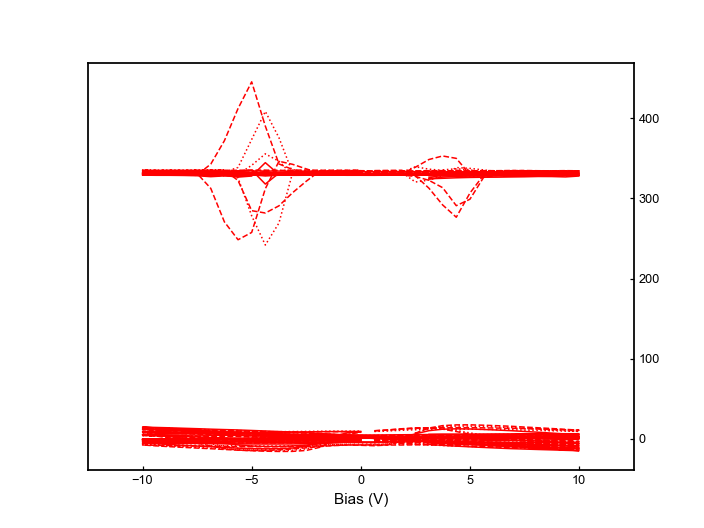

<IPython.core.display.Javascript object>


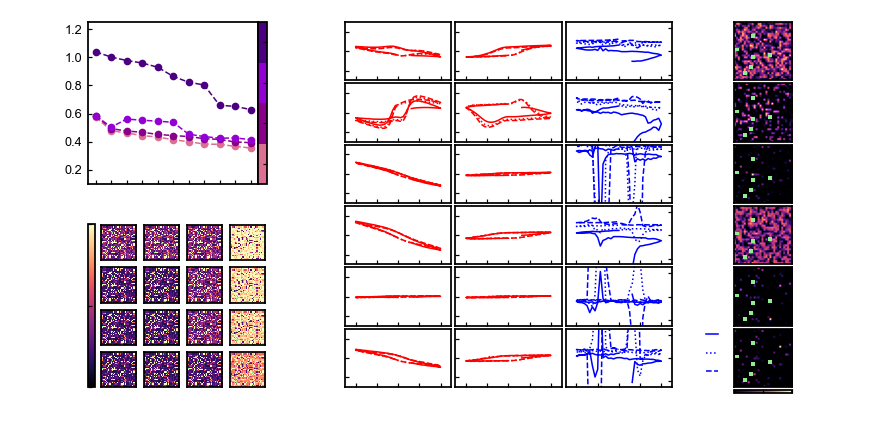

In [35]:
###Supplementary Outlier Removal- DL Analysis Plotter#### 
#####N=6,alpha=1#######
plt.close('all')
comps_6, maps_6,lims_dict_pr_6,lims_dict_res_6=find_ind(6,0)
fig = plt.figure(figsize=(8.0,4.0), dpi=100)
gs = fig.add_gridspec(3, 5, width_ratios=[0.05,0.75,0.35,1,1],height_ratios=[1.0,0.255,1],wspace=0.0,hspace=0.0,
                      top=0.95, bottom=0.12, left=0.1, right=0.9)
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
plt.rcParams['font.size'] = 10

idx = pd.IndexSlice

#####Part A

gs_subline = gs[0,0:2].subgridspec(1, 2, width_ratios=[1,0.05],wspace=0.0)

ax_line = fig.add_subplot(gs_subline[0])

c = ['palevioletred', 'darkmagenta','darkviolet', 'indigo']
cscale = matplotlib.colors.ListedColormap(c)
boundaries = np.arange(len(c)+1)-0.5+2
norm = matplotlib.colors.BoundaryNorm(boundaries, cscale.N, clip=True)


ax_cbar = fig.add_subplot(gs_subline[1])


bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cscale,
                                norm=norm,
                                boundaries=boundaries,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='vertical')



for i in range(4):
    j = [1,2,3,4][i]
    error_data = new_errors.loc[:,idx[:,j]]

    length = recon_df.shape[1]
    rms = np.sqrt(error_data/length).replace([np.inf,-np.inf],np.nan)
    mean_rms = rms.mean(skipna=True)
    std_rms = rms.std(skipna=True)
    mean_rms

    ax_line.plot(np.arange(2,13),mean_rms.values,'.--', markersize=8, color=c[i], label=str(j))#, yerr=std_rms.values)
    #ax_line.set_xlabel('N')
    ax_line.set_xticks(np.arange(2,13))
    ax_line.set_xticklabels([])
    
    #ax_line.set_ylabel('Mean RMS Error',fontsize=10)
    ax_line.yaxis.set_label_coords(-0.2,0.5)
    ax_line.set_ylim([0.1,1.25])
    #ax_line.set_yticks([0.2,0.4,0.6,0.8,1.0])
    #ax_line.set_yticklabels([])

ax_cbar.set_yticklabels([ ])
#ax_cbar.set_ylabel(r'$\alpha$',fontsize=10)
ax_cbar.yaxis.set_label_coords(3,0.5)


####### Part B ##########
gs_maps = gs[2,1].subgridspec(4, 4, width_ratios = [1,1,1,1], wspace=0.1,hspace=0.2)

letter = ['b.','c.','d.','e.','f.','g.','h.','i.','j.']

comp_map_list = [0,2,4,6]       ###########This coressponds to the index of the num of comps list in the above cell
comps_list = ['2','4','6','6']                                        ## To N=2,4,6 and 8 in RMS maps 


for j, alp in enumerate(global_alp):
    for i, comps in enumerate(comp_map_list):
        error_data = errors[comps][alp]
        length = recon_df.shape[1]
        rms = np.sqrt(error_data/length).replace([np.inf,0.000,-np.inf],np.nan)
        ax = fig.add_subplot(gs_maps[i,j])
        cmap = copy.copy(cm.get_cmap('magma'))
        cmap.set_bad('lightgreen')
        im=np.reshape(rms.values,(30,30))
        im=np.rot90(im)
        im = ax.imshow(im, cmap=cmap,origin='lower', interpolation='none' ,vmin=0.0, vmax=1.0)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.yaxis.set_label_position('right')
       
    
ax_c =fig.add_axes([0.1, 0.12, 0.008, 0.37])
plt.colorbar(im, cax=ax_c, orientation='vertical', label=' ',pad=0)
plt.locator_params(nbins=2)
ax_c.set_yticklabels([ ])
ax_c.yaxis.set_label_position('left')
ax_c.yaxis.set_ticks_position('left')
ax_c.yaxis.set_label_coords(-4.5,0.5)

##### Part C #########
gs_dl= gs[:,3:].subgridspec(6, 1, height_ratios=[1,1,1,1,1,1],hspace=0.05)

analysis=comps_6
maps=maps_6
ylabel=False
xlabel=False
position='left'
h=0.55
offx=0.0
offy=0.5

for i in [0,1,2,3,4,5]:
    gs_1= gs_dl[i,0].subgridspec(1,5, height_ratios=[1], width_ratios =[1,1,1,0.5,h], hspace=0.05,wspace=0.05)
    handles, labels, ax_map, map_im, ax_1, ax_2, ax_3=single_DL(i,maps,ylabel,xlabel,position,h,lims_dict_pr_6,lims_dict_res_6)
    #ax_map.annotate(r"$N_{{{}}}$".format(i+1),(-0.25,0.88),xycoords='axes fraction',fontsize=12)
    ax_1.set_ylabel(' ')
    ax_1.set_ylim([-30, 30])
    ax_1.set_yticks([-20,0,20])
    ax_2.set_ylabel(' ')
    ax_2.set_ylim([-30, 30])
    ax_2.set_yticks([-20,0,20])
    ax_2.yaxis.set_label_position('left')
    ax_2.yaxis.set_label_coords(-0.15,0.50)
    ax_3.set_ylim([325, 335])
    ax_3.set_ylabel(' ')
    ax_3.set_yticks([326, 330, 334])

ax_color = fig.add_subplot(gs[0,2])
ip = InsetPosition(ax_map, [0,-0.1,1.0,0.05]) 
ax_color.set_axes_locator(ip)
plt.colorbar(map_im,cax=ax_color, orientation='horizontal',label=" ", pad=5)
plt.locator_params(nbins=2)
ax_color.set_xticklabels([])
ax_color.yaxis.set_label_position(position)
ax_color.yaxis.set_ticks_position(position)
fig.align_xlabels([ax,ax_color,ax_1, ax_2, ax_3])
fig.align_ylabels([ax_line,ax_color])
labels=[" "," "," "]
fig.legend(handles, labels,loc=((0.7965,0.13)),ncol=1,fontsize=8,frameon=False,handletextpad=0.1,framealpha=0.1,handlelength=1)
plt.show()

In [ ]:
plt.savefig('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\Figures\\DL_Sup_08-07-2021.png',dpi=400)

<IPython.core.display.Javascript object>


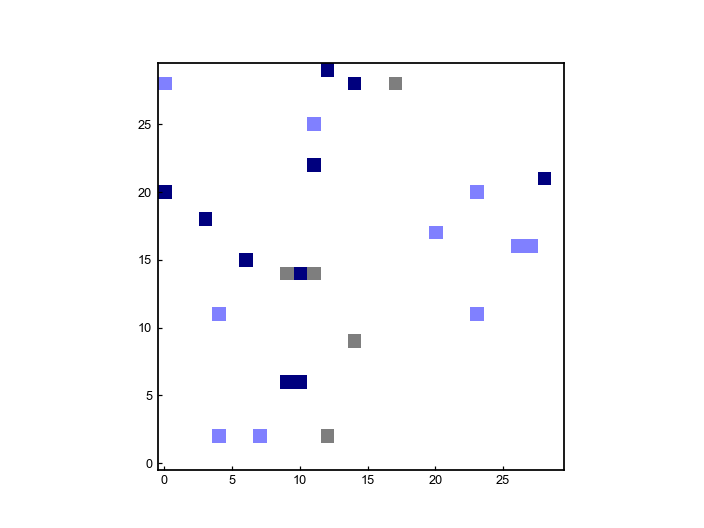

[9 101 194 285 293 315 323 337 345 360 387 421 440 511 848]
[1 138 147 237 334 612 699 708 793 823]


<IPython.core.display.Javascript object>


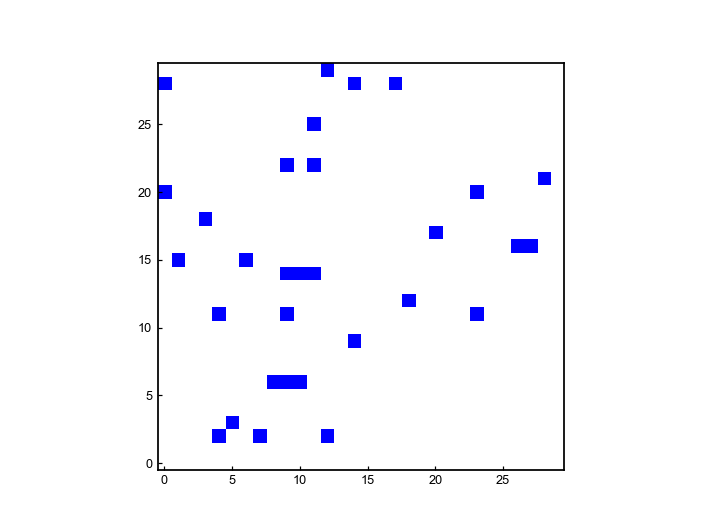

31
[  1   9  44 101 138 147 176 194 237 263 277 285 288 293 315 323 334 337
 345 360 387 421 440 511 557 612 699 708 793 823 848]


In [36]:
#########Extracting Further Outliers from high N Dictionary Learning Analysis
#####N=6,alpha=1#######
from numpy import inf
A=maps_6[2]
A[A==-inf]=np.nan
A[A==inf]=np.nan
B=maps_6[5]
B[B==-inf]=np.nan
B[B==inf]=np.nan
colors = ["white","b"]
cmap_B =  matplotlib.colors.ListedColormap(colors)

mask_A = np.full((900),False) #### array of false
mask_A[np.where(A>0.25)[0]]=True
mask_map_A = np.rot90(mask_A.reshape(30,30))   ###### map of points in the beahvior

mask_B = np.full((900),False) #### array of false
mask_B[np.where(B>0.25)[0]]=True
mask_map_B = np.rot90(mask_B.reshape(30,30))   ###### map of points in the beahvior

plt.figure()
fig=plt.plot(constrained_layout=True)
plt.imshow(mask_map_A,cmap='binary',origin='lower')
plt.imshow(mask_map_B,cmap=cmap_B,alpha=0.5,origin='lower')

C=np.where(mask_A==True)[0].astype(list)
D=np.where(mask_B==True)[0].astype(list)
D=D[~np.isin(D,C)]
print((C))
print((D))

mask_fin = np.full((900),False) #### array of falsemask[176]=True
mask_fin[np.where(mask==True)]=True
for i in C:
    mask_fin[i]=True
for i in D:
    mask_fin[i]=True

plt.figure()
fig=plt.plot(constrained_layout=True)
plt.imshow(np.rot90(mask_fin.reshape(30,30)),cmap=cmap_B, origin='lower')
print(len(np.where(mask_fin==True)[0]))
print((np.where(mask_fin==True)[0]))

### Main Text Analysis 

In [37]:
plt.close('all')
analysis_data= PR_res     # Stacked Analysis object                                                 
flags = mask_fin                       ###### Masked outliers identified by K-means

In [38]:
### Dictionary Learning Error Estimator


global_alp = [1,10,20,30]          # Alpha's to loop through
num_of_comps = [2,3,4,5,6,7,8,9,10,11,12]           # Num. Components to loop through
errors = []                        # Place to store all of the errors

all_comps_comps = []               # Place to store all of the resulting components
all_comps_maps = []                # Place to store all of the resulting maps

for global_n in num_of_comps:      # For each number of components

    comps = []                     # List of all of the resulting components
    maps = []                      # List of all of the resulting maps

    # Run analyses
    for alp in global_alp:         # For each alpha
        DL_components, DL_loading_maps = dict_learn(global_n,analysis_data,flags,alp=alp)   # Get the components/maps for a given Num. Comp. and Alpha. This is the function I defined above.

        comps.append(DL_components)    # Add comps to list of comps
        maps.append(DL_loading_maps)   # Add maps to list of maps

        
    all_total = pd.DataFrame(np.full((900,len(global_alp)),0.0), index=analysis_data.index, columns = global_alp)

    # Calculate error
    for i, alp in enumerate(global_alp):
        map_data = maps[i]          # Get maps
        comp_data = comps[i]        # Get Data

        recon =  map_data.dot(comp_data)       # Reconstruct data from results
        recon_df = pd.DataFrame(recon, index=analysis_data.index, columns=analysis_data.columns) # Convert to data frame
        total_sse = ((recon_df-analysis_data)**2).sum(axis=1)    # Sum of squared errors
        all_total[global_alp[i]] = total_sse             # Store
    
    all_comps_comps.append(comps)   # Store comps
    all_comps_maps.append(maps)     # Store maps

    errors.append(all_total)        # Store errors

all_errors = pd.concat(errors,axis=1)          # Convert errors
new_errors = pd.DataFrame(all_errors.values,index=all_errors.index, columns=pd.MultiIndex.from_product([np.arange(2,13), [1,2,3,4]],names=['Comps', 'Alp'])) # Convert errors
print('Dunzo')

Dunzo


### Main Text Figure 3

<IPython.core.display.Javascript object>


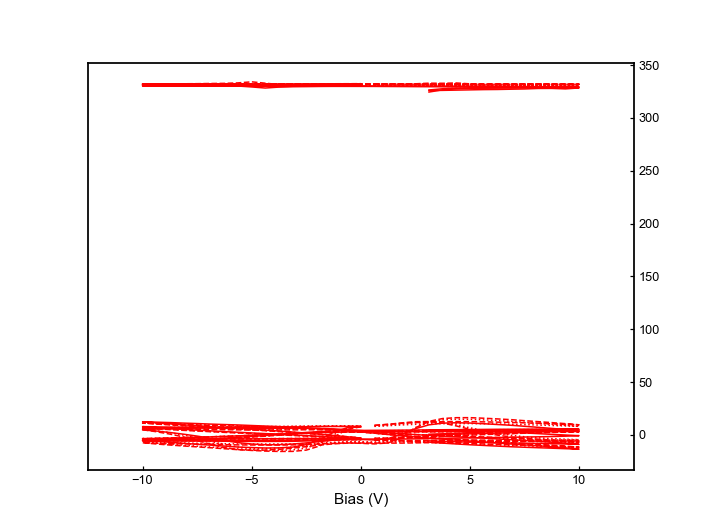

<IPython.core.display.Javascript object>


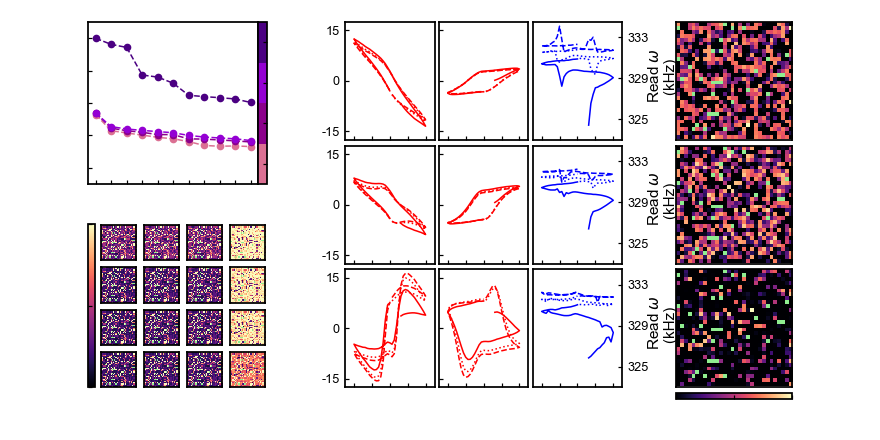

In [39]:
###Main Text DL Analysis Plotter#### 
#####N=3,alpha=20#######
comps_3, maps_3,lims_dict_pr_3,lims_dict_res_3=find_ind(3,2)

fig = plt.figure(figsize=(8.0,4.0), dpi=100)
gs = fig.add_gridspec(3, 5, width_ratios=[0.05,0.75,0.35,1,1],height_ratios=[1.0,0.255,1],wspace=0.0,hspace=0.0,
                      top=0.95, bottom=0.12, left=0.1, right=0.9)
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
plt.rcParams['font.size'] = 10

idx = pd.IndexSlice

#####Part A

gs_subline = gs[0,0:2].subgridspec(1, 2, width_ratios=[1,0.05],wspace=0.0)

ax_line = fig.add_subplot(gs_subline[0])

c = ['palevioletred', 'darkmagenta','darkviolet', 'indigo']
cscale = matplotlib.colors.ListedColormap(c)
boundaries = np.arange(len(c)+1)-0.5+2
norm = matplotlib.colors.BoundaryNorm(boundaries, cscale.N, clip=True)


ax_cbar = fig.add_subplot(gs_subline[1])


bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cscale,
                                norm=norm,
                                boundaries=boundaries,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='vertical')


comp_map_list = [0,1,2,3]       ###########This coressponds to the index of the num of comps list in the above cell
                                        ## To N=2,3,and 4 in RMS maps 

for i in range(4):
    j = [1,2,3,4][i]
    error_data = new_errors.loc[:,idx[:,j]]

    length = recon_df.shape[1]
    rms = np.sqrt(error_data/length).replace([np.inf,-np.inf],np.nan)
    mean_rms = rms.mean(skipna=True)
    std_rms = rms.std(skipna=True)
    mean_rms

    ax_line.plot(np.arange(2,13),mean_rms.values,'.--', markersize=8, color=c[i], label=str(j))#, yerr=std_rms.values)
    #ax_line.set_xlabel('N')
    ax_line.set_xticks(np.arange(2,13))
    ax_line.set_xticklabels([])
    
    #ax_line.set_ylabel('Mean RMS Error',fontsize=10)
    ax_line.yaxis.set_label_coords(-0.2,0.5)
    ax_line.set_ylim([0.1,1.1])
    ax_line.set_yticks([0.2,0.4,0.6,0.8,1.0])
    ax_line.set_yticklabels([])

ax_cbar.set_yticklabels([ ])
#ax_cbar.set_ylabel(r'$\alpha$',fontsize=10)
ax_cbar.yaxis.set_label_coords(3,0.5)


####### Part B ##########
gs_maps = gs[2,1].subgridspec(4, 4, width_ratios = [1,1,1,1], wspace=0.1,hspace=0.2)

letter = ['b.','c.','d.','e.','f.','g.','h.','i.','j.']
comps_list = ['2','3','4','5']

for j, alp in enumerate(global_alp):
    for i, comps in enumerate(comp_map_list):
        error_data = errors[comps][alp]
        length = recon_df.shape[1]
        rms = np.sqrt(error_data/length).replace([np.inf,0.000,-np.inf],np.nan)
        ax = fig.add_subplot(gs_maps[i,j])
        cmap = copy.copy(cm.get_cmap('magma'))
        cmap.set_bad('lightgreen')
        im=np.reshape(rms.values,(30,30))
        im=np.rot90(im)
        im = ax.imshow(im, cmap=cmap,origin='lower', interpolation='none' ,vmin=0.0, vmax=1.0)#norm=LogNorm(vmin=0.15, vmax=0.75)) #)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.yaxis.set_label_position('right')
       
    
ax_c =fig.add_axes([0.1, 0.12, 0.008, 0.37])
plt.colorbar(im, cax=ax_c, orientation='vertical', label=' ',pad=0)
plt.locator_params(nbins=2)
ax_c.set_yticklabels([ ])
ax_c.yaxis.set_label_position('left')
ax_c.yaxis.set_ticks_position('left')
ax_c.yaxis.set_label_coords(-4.5,0.5)

##### Part C #########
gs_dl= gs[:,3:].subgridspec(3, 1, height_ratios=[1,1,1],hspace=0.05)

analysis=comps_3
maps=maps_3
ylabel=True
xlabel=False
position='left'
h=1.3
offx=0.0
offy=0.5

for i,j in zip([0,1,2],[0,2,1]):
        gs_1= gs_dl[i,0].subgridspec(1,5, height_ratios=[1], width_ratios =[1,1,1,0.5,h], hspace=0.05,wspace=0.05)
        handles, labels, ax_map, map_im, ax_1, ax_2, ax_3=single_DL(j,maps,ylabel,xlabel,position,h,lims_dict_pr_3,lims_dict_res_3)
        ax_1.set_ylabel(' ')
        ax_1.set_ylim([-17.5, 17.5])
        ax_1.set_yticks([-15,0,15])
        ax_2.set_ylabel(' ')
        ax_2.set_ylim([-17.5, 17.5])
        ax_2.set_yticks([-15,0,15])
        ax_2.yaxis.set_label_position('left')
        ax_2.yaxis.set_label_coords(-0.15,0.50)
        ax_3.set_ylim([323, 334.5])
        #ax_3.set_ylabel(' ')
        ax_3.set_yticks([325, 329, 333])

        
ax_color = fig.add_subplot(gs[0,2])
ip = InsetPosition(ax_map, [0,-0.1,1.0,0.05]) 
ax_color.set_axes_locator(ip)
plt.colorbar(map_im,cax=ax_color, orientation='horizontal',label=" ", pad=5)
plt.locator_params(nbins=2)
ax_color.set_xticklabels([])
ax_color.yaxis.set_label_position(position)
ax_color.yaxis.set_ticks_position(position)

labels=[" "," "," "]
#fig.legend(handles, labels,loc=((0.45,0.03)),ncol=3,fontsize=8,frameon=False,handletextpad=0.3,framealpha=0.1,handlelength=1)
plt.show()
#plt.savefig('C:\\Users\\keris\\Desktop\\BEPS PTP Data\\Writing\\Figures\\DL_main_.png',dpi=300)

In [ ]:
plt.savefig('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\Figures\\DL_Main_08-07-2021.png',dpi=400)

### Main Figure 4

<IPython.core.display.Javascript object>


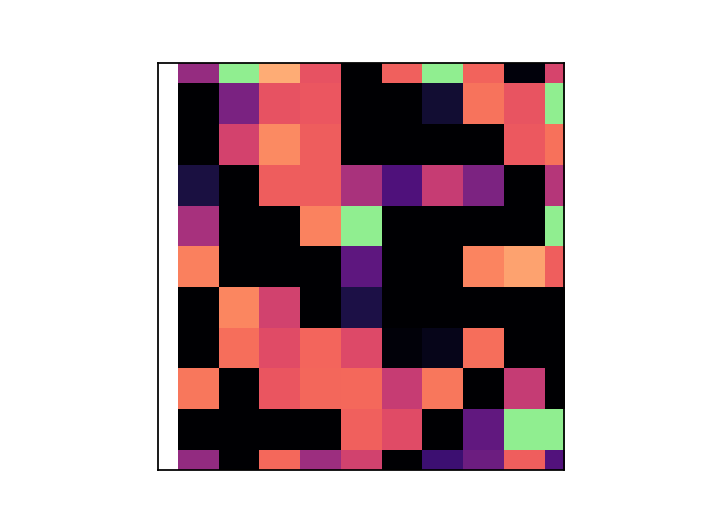

(-1.0, 9.0)

In [41]:
#######Make Component Inset grid images for Figure 4 and Supplemtnary Figure S17
fig=plt.figure()
ax_map=fig.add_subplot()
#plt.imshow(im_amp)
Map_DL(0,maps_3)
ax_map.set_ylim(5,15)
ax_map.set_xlim(-1,9)

In [40]:
plt.close('all')

### Supplemental DL Figure S13

In [ ]:
plt.close('all')

<IPython.core.display.Javascript object>


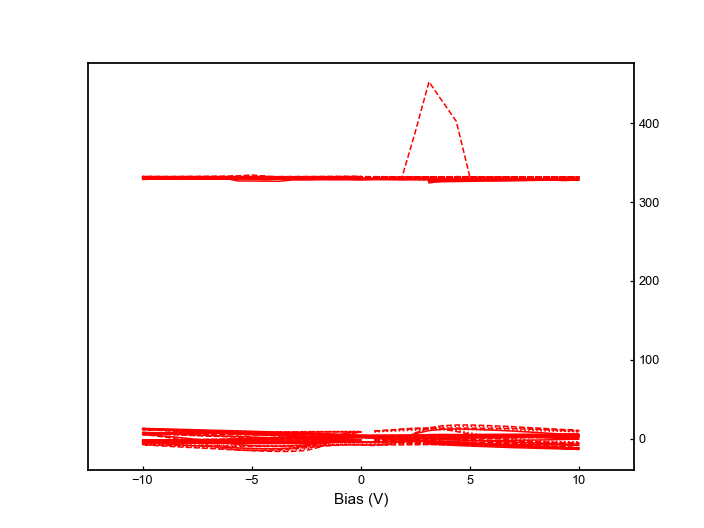

<IPython.core.display.Javascript object>


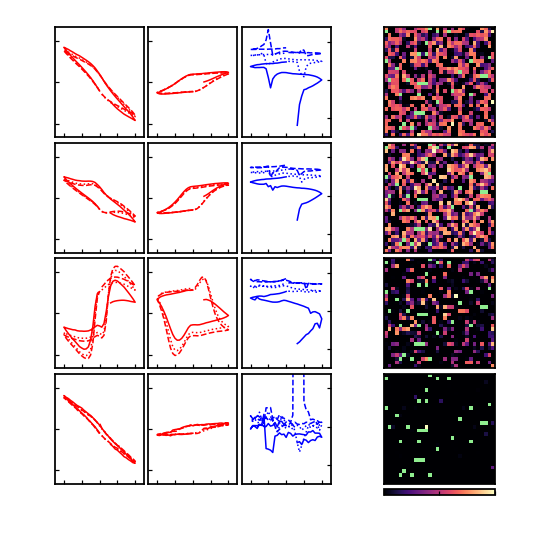

In [43]:
###DL Text DL Analysis Plotter#### 
#####N=4,alpha=20#######
comps_4, maps_4,lims_dict_pr_4,lims_dict_res_4=find_ind(4,2)
fig = plt.figure(figsize=(5.0,5.0), dpi=100)
gs = fig.add_gridspec(1, 1,wspace=0.0,hspace=0.0,
                      top=0.95, bottom=0.12, left=0.1, right=0.9)
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
plt.rcParams['font.size'] = 10


gs_dl= gs[:,0:].subgridspec(4, 1, height_ratios=[1,1,1,1],hspace=0.05)

analysis=comps_4
maps=maps_4
ylabel=False
xlabel=False
position='left'
h=1.25
offx=0.0
offy=0.5

for i,j in zip([0,1,2,3],[0,2,1,3]):
        gs_1= gs_dl[i,0].subgridspec(1,5, height_ratios=[1], width_ratios =[1,1,1,0.5,h], hspace=0.05,wspace=0.05)
        handles, labels, ax_map, map_im, ax_1, ax_2, ax_3=single_DL(j,maps,ylabel,xlabel,position,h,lims_dict_pr_4,lims_dict_res_4)
        ax_1.set_ylabel(' ')
        ax_1.set_ylim([-20, 20])
        ax_1.set_yticks([-15,0,15])
        ax_2.set_ylabel(' ')
        ax_2.set_ylim([-20, 20])
        ax_2.set_yticks([-15,0,15])
        ax_2.yaxis.set_label_position('left')
        ax_2.yaxis.set_label_coords(-0.15,0.50)
        ax_3.set_ylim([323, 334.5])
        ax_3.set_ylabel(' ')
        ax_3.set_yticks([325, 329, 333])

        
ax_color = fig.add_subplot(gs[0,0])
ip = InsetPosition(ax_map, [0,-0.1,1.0,0.05]) 
ax_color.set_axes_locator(ip)
plt.colorbar(map_im,cax=ax_color, orientation='horizontal',label=" ", pad=5)
plt.locator_params(nbins=2)
ax_color.set_xticklabels([])
ax_color.yaxis.set_label_position(position)
ax_color.yaxis.set_ticks_position(position)

labels=[" "," "," "]
#fig.legend(handles, labels,loc=((0.45,0.03)),ncol=3,fontsize=8,frameon=False,handletextpad=0.3,framealpha=0.1,handlelength=1)
plt.show()
#plt.savefig('C:\\Users\\keris\\Desktop\\BEPS PTP Data\\Writing\\Figures\\DL_main_.png',dpi=300)

### Supplementary Figure S15

In [53]:
##### Plot Functions to plot compenent with color changing markers 
def plot_colourline(x,y,c,linestyle):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['b','r'])
    c = cmap((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]],linestyle, c=c[i])
        plt.xlabel("Bias (V)")
        ax.set_xlim([-12.5,12.5])
        ax.set_xticks([-10,-5, 0,5, 10])
    return


def plot_read_pr(analysis,comp):
    x=dc
    x0 = dc[4:]
    y1=(analysis['PR_r0'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"] #cycle 1
    c1=analysis['PR_r0'].columns.get_level_values('chirp#')
    y2=(analysis['PR_r1'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"]#cycle 2
    c2=analysis['PR_r1'].columns.get_level_values('chirp#')
    y3=(analysis['PR_r2'].iloc[comp:comp+1].values[0]*read_devs['PR'])+read_means["PR"]#cycle 3
    c3=analysis['PR_r2'].columns.get_level_values('chirp#')
    plot_colourline(x0,y1,c1,linestyle='-')
    plot_colourline(x,y2,c2,linestyle=':')
    plot_colourline(x,y3,c3,linestyle='--')
    return  

def plot_write_pr(analysis,comp):
    x=dc
    x0 = dc[4:]
    y1=(analysis['PR_w0'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"] #cycle 1
    c1=analysis['PR_w0'].columns.get_level_values('chirp#')
    y2=(analysis['PR_w1'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"]#cycle 2
    c2=analysis['PR_w1'].columns.get_level_values('chirp#')
    y3=(analysis['PR_w2'].iloc[comp:comp+1].values[0]*write_devs['PR'])+write_means["PR"]#cycle 3
    c3=analysis['PR_w2'].columns.get_level_values('chirp#')
    plot_colourline(x0,y1,c1,linestyle='-')
    plot_colourline(x,y2,c2,linestyle=':')
    plot_colourline(x,y3,c3,linestyle='--')
    return

def plot_read_res(analysis,comp):
    x=dc
    x0 = dc[4:]
    y1=(analysis['Res_r0'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"] #cycle 1
    c1=analysis['Res_r0'].columns.get_level_values('chirp#')
    y2=(analysis['Res_r1'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"]#cycle 2
    c2=analysis['Res_r1'].columns.get_level_values('chirp#')
    y3=(analysis['Res_r2'].iloc[comp:comp+1].values[0]*read_devs['Res'])+read_means["Res"]#cycle 3
    c3=analysis['Res_r2'].columns.get_level_values('chirp#')
    plot_colourline(x0,y1,c1,linestyle='-')
    plot_colourline(x,y2,c2,linestyle=':')
    plot_colourline(x,y3,c3,linestyle='--',)
    return

<IPython.core.display.Javascript object>


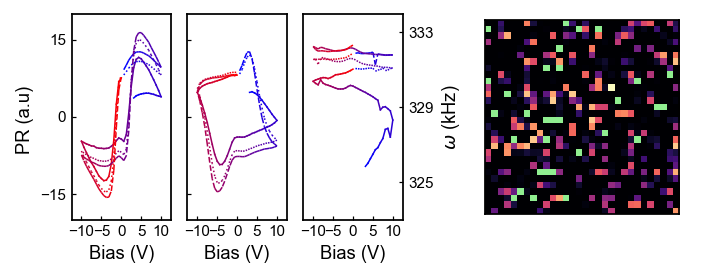

In [54]:
####### EXTRA PLot of Each Component on a Color change ing line use plot_colour line

plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(6.5,2.5), dpi=100)
gs = fig.add_gridspec(1, 1,wspace=0.0,hspace=0.0,top=0.95, bottom=0.2, left=0.1, right=0.95)

analysis=comps_3
maps=maps_3
comp=1
c_map=1
h=1.95
gs_1= gs[0,0].subgridspec(1,5, height_ratios=[1], width_ratios =[1,1,1,0.5,h], hspace=0.05,wspace=0.15)

ax_1=fig.add_subplot(gs_1[0,0])
plot_write_pr(analysis,comp)

ax_2=fig.add_subplot(gs_1[0,1])
plot_read_pr(analysis,comp)


ax_3=fig.add_subplot(gs_1[0,2])
plot_read_res(analysis,comp)

ax_4=fig.add_subplot(gs_1[0,4])
Map_DL(c_map,maps)

ax_1.set_ylabel('PR (a.u) ')
ax_1.set_ylim([-20, 20])
ax_1.set_yticks([-15,0,15])
ax_2.set_ylabel(' ')
ax_2.set_ylim([-20, 20])
ax_2.set_yticks([-15,0,15])
ax_2.set_yticklabels([])
ax_3.yaxis.set_label_position('right')
ax_3.yaxis.set_ticks_position('right')
ax_3.set_ylim([323, 334])
ax_3.set_ylabel('$\omega$ (kHz) ')
ax_3.set_yticks([325, 329, 333])


In [ ]:
plt.close('all')

### Supplementary Figure S20

In [55]:
def recon_responses(pnt):
    norm=maps_3[0][pnt]+maps_3[1][pnt]+maps_3[2][pnt]
    for i in [0,1,2]:
        print("Comp Wieght {}: {:.2f}".format(i+1,(maps_3[i][pnt]/norm)))
    cw0=(maps_3[0][pnt]/norm)
    cw1=(maps_3[1][pnt]/norm)
    cw2=(maps_3[2][pnt]/norm)

    poi_comps=(cw0*comps_3.iloc[0,:])+(cw1*comps_3.loc[1,:])+(cw2*comps_3.loc[2,:])
    poi_comps=pd.DataFrame(poi_comps)
    poi_comps=poi_comps.transpose()
    return poi_comps,cw0,cw1,cw2

def plot_combo_1(df,c):    #: here Read PR response
    x=dc
    x0 = dc[4:]

    y1=(df['PR_r0'].values[0]*read_devs['PR'])+read_means["PR"]#cycle 1
    y2=(df['PR_r1'].values[0]*read_devs['PR'])+read_means["PR"]#cycle 2
    y3=(df['PR_r2'].values[0]*read_devs['PR'])+read_means["PR"]#cycle 3
   
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
    list3=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list3.append(data.max())
        list3.append(data.min())
    fig = plt.gcf()
    ax = plt.gca()
    
    ymin=min(list3)
    ymax=max(list3)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)",fontsize=10)
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax

def plot_combo_2(df,c):    #: here Read Res response
    x=dc
    x0 = dc[4:]

    y1=(df['Res_r0'].values[0]*read_devs['Res'])+read_means["Res"]#cycle 1
    y2=(df['Res_r1'].values[0]*read_devs['Res'])+read_means["Res"]#cycle 2
    y3=(df['Res_r2'].values[0]*read_devs['Res'])+read_means["Res"]#cycle 3
   
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
    list3=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list3.append(data.max())
        list3.append(data.min())
    fig = plt.gcf()
    ax = plt.gca()
    
    ymin=min(list3)
    ymax=max(list3)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)",fontsize=10)
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax


def plot_combo_3(df,c):    #: here Write PR response
    x=dc
    x0 = dc[4:]

    y1=(df['PR_w0'].values[0]*write_devs['PR'])+write_means["PR"]#cycle 1
    y2=(df['PR_w1'].values[0]*write_devs['PR'])+write_means["PR"]#cycle 2
    y3=(df['PR_w2'].values[0]*write_devs['PR'])+write_means["PR"]#cycle 3
   
    plt.plot(x0,y1,color=c,linestyle='-', markersize=1.5,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle=':', markersize=1.5,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='--', markersize=1.5,label='cycle 3')
    list3=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        list3.append(data.max())
        list3.append(data.min())
    fig = plt.gcf()
    ax = plt.gca()
    
    ymin=min(list3)
    ymax=max(list3)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlabel("Bias (V)",fontsize=10)
    ax.set_xlim([-12.5,12.5])
    ax.set_xticks([-10,-5, 0,5, 10])
    return ymin,ymax

Comp Wieght 1: 0.16
Comp Wieght 2: 0.05
Comp Wieght 3: 0.79


<IPython.core.display.Javascript object>


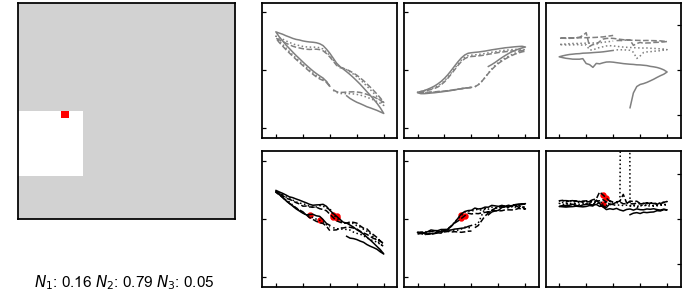

In [46]:
plt.rcParams['font.size'] = 10
pnt=195
poi_comps,cw0,cw1,cw2=recon_responses(pnt)
fig= plt.figure(figsize=(6.25,2.75), dpi=100)
gs = fig.add_gridspec(1, 2, width_ratios=[1.0,1.75],height_ratios=[1],wspace=0.05,hspace=0.05,
                      top=0.99, bottom=0.05, left=0.01, right=0.99)
analysis=comps_3
maps=maps_3
ylabel=True
xlabel=False
position='left'
h=0.5
pnt=pnt

pr_min=lims_dict_pr_3['min']
pr_max=lims_dict_pr_3['max']
incr_pr=lims_dict_pr_3['incr']
pr_range=lims_dict_pr_3['range']
    
res_min=lims_dict_res_3['min']
res_max=lims_dict_res_3['max']
incr_res=lims_dict_res_3['incr']
res_range=lims_dict_res_3['range']

weights=[cw0,cw2,cw1]


gs_map = gs[0,0].subgridspec(2, 1, width_ratios=[1],height_ratios=[1,0.25],wspace=0.05,hspace=0.1)
ax_map = fig.add_subplot(gs_map[0,0])

pntX=np.full((900),False)
pntX[pnt]=True
im1=pntX.reshape(30,30)
im1=np.rot90(im1)
colors = ["white","red"]
cmap1 =  matplotlib.colors.ListedColormap(colors)

plt.imshow(im1,cmap=cmap1,origin='lower',interpolation='none', alpha=1)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
#ax_map.annotate("Point = "+str(pnt),(0.01,0.85),xycoords='axes fraction',fontweight='normal')
roi_mask=np.full((900), True)
roi_mask=roi_mask.reshape(30,30)
for i in [6,7,8,9,10,11,12,13,14]:
    for j in[0,1,2,3,4,5,6,7,8]:
        roi_mask[i,j]=False
        
colors = ["white","grey"]
cmap2 =  matplotlib.colors.ListedColormap(colors)
# Get the colormap colors
my_cmap = cmap2(np.arange(2))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1,2)
# Create new colormap
my_cmap = ListedColormap(my_cmap)
ax_map.imshow(roi_mask,cmap=my_cmap,origin='lower',interpolation='none',alpha=0.35)
ax_map.annotate("$N_{}$: {:.2f} $N_{}$: {:.2f} $N_{}$: {:.2f}".format(1,weights[0],2,weights[1],3,weights[2]),(0.05,0.05),xycoords='figure fraction',color='black',fontsize=10)
        

#########Compare Reconstrcuted combinations of of DL behaviors with input responses at a specific piont
gs_vs = gs[0,1].subgridspec(2, 3, width_ratios=[1,1,1],height_ratios=[1,1],wspace=0.05,hspace=0.1)
ax=fig.add_subplot(gs_vs[0,0])
plot_combo_3(poi_comps,'grey')
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylim(-14,14)
ax.set_yticks([-12,0,12])
ax.xaxis.set_ticklabels([ ])
ax.yaxis.set_ticklabels([ ])
plt.xlabel(" ")
plt.ylabel(' ')


ax=fig.add_subplot(gs_vs[1,0])
plot_nan(write_nan,write_1,"PR",pnt,False,'black')
ax.yaxis.tick_left()
ax.set_ylim(-14,14)
ax.set_yticks([-12,0,12])
ax.yaxis.set_ticklabels([ ])
plt.ylabel(" ")
plt.xlabel(" ")

ax=fig.add_subplot(gs_vs[0,1])
plot_combo_1(poi_comps,'grey')
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylim(-14,14)
ax.set_yticks([-12,0,12])
ax.yaxis.set_ticklabels([ ])
ax.xaxis.set_ticklabels([ ])
plt.xlabel(" ")
plt.ylabel(' ')

ax=fig.add_subplot(gs_vs[1,1])
plot_nan(read_nan,read_1,"PR",pnt,False,'black')
ax.yaxis.tick_left()
ax.set_ylim(-14,14)
ax.set_yticks([-12,0,12])
ax.yaxis.set_ticklabels([ ])
plt.xlabel(" ")
plt.ylabel(' ')


ax=fig.add_subplot(gs_vs[0,2])
plot_combo_2(poi_comps,'grey')
ax.set_ylim([res_min-incr_res, res_max+incr_res])
ax.set_yticks([res_min+incr_res,((res_min)+(res_range/2)),res_max-incr_res])
ax.xaxis.set_ticklabels([ ])
ax.yaxis.set_ticklabels([ ])
plt.xlabel(" ")
plt.ylabel(' ')

ax=fig.add_subplot(gs_vs[1,2])
plot_nan(read_nan,read_1,"Res",pnt,False,'black')
ax.set_ylim([res_min-incr_res, res_max+incr_res])
ax.set_yticks([res_min+incr_res,((res_min)+(res_range/2)),res_max-incr_res])
plt.xlabel(" ")
plt.ylabel(' ')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticklabels([ ])

handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels,loc=((0.5,0.02)),ncol=4,fontsize=10,frameon=False,handletextpad=0.5,handlelength=1)
plt.show()

In [56]:
plt.close('all')